# Block #1

## ResourceManager screens

![nn-1](./images/nn-1.png)
![nn-2](./images/nn-2.png)

## NodeName screens

![nr-1](./images/rm-1.png)

## Loading file to Hadoop

In [ ]:
%cd '/opt/itmo-bigdata/hw1'

In [ ]:
!pip install poetry
!poetry config virtualenvs.create false
!poetry install --no-root

In [ ]:
import pyarrow as pa
from pathlib import Path

fs = pa.hdfs.connect(host='namenode', port=8020, user='root')

local_path = Path('hadoop-notebook/test.txt')
hdfs_path = Path('/hamlet/test.txt')

hdfs_directory = hdfs_path.parent.as_posix()
if not fs.exists(hdfs_directory):
    fs.mkdir(hdfs_directory)

with open(local_path, 'rb') as local_file:
    file_data = local_file.read()

with fs.open(hdfs_path.as_posix(), 'wb') as hdfs_file:
    hdfs_file.write(file_data)

fs.close()

## NameNode after adding text.txt

![nn-3](./images/nn-3.png)
![nn-4](./images/nn-3.png)

## Check test file in hadoop

In [4]:
!hadoop fs -ls /hamlet

Found 1 items
-rw-r--r--   3 root supergroup       8845 2023-11-30 01:21 /hamlet/test.txt


In [5]:
!hadoop fs -cat /hamlet/test.txt

ACT III

SCENE I. A room in the castle.
(Enter KING CLAUDIUS, QUEEN GERTRUDE, POLONIUS, OPHELIA, ROSENCRANTZ, and GUILDENSTERN)

KING CLAUDIUS
And can you, by no drift of circumstance,
Get from him why he puts on this confusion,
Grating so harshly all his days of quiet
With turbulent and dangerous lunacy?

ROSENCRANTZ
He does confess he feels himself distracted;
But from what cause he will by no means speak.

GUILDENSTERN
Nor do we find him forward to be sounded,
But, with a crafty madness, keeps aloof,
When we would bring him on to some confession
Of his true state.

QUEEN GERTRUDE
Did he receive you well?

ROSENCRANTZ
Most like a gentleman.

GUILDENSTERN
But with much forcing of his disposition.

ROSENCRANTZ
Niggard of question; but, of our demands,
Most free in his reply.

QUEEN GERTRUDE
Did you assay him?
To any pastime?

ROSENCRANTZ
Madam, it so fell out, that certain players
We o'er-raught on the way: of these we told him;
And there did seem in him a kind of joy
To hear of it: th

## Implementation of Pi approximation using MapReduce

In [6]:
!hadoop jar /opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.6.jar pi 15 1800

Number of Maps  = 15
Samples per Map = 1800
Wrote input for Map #0
Wrote input for Map #1
Wrote input for Map #2
Wrote input for Map #3
Wrote input for Map #4
Wrote input for Map #5
Wrote input for Map #6
Wrote input for Map #7
Wrote input for Map #8
Wrote input for Map #9
Wrote input for Map #10
Wrote input for Map #11
Wrote input for Map #12
Wrote input for Map #13
Wrote input for Map #14
Starting Job
2023-11-30 01:22:35 INFO  DefaultNoHARMFailoverProxyProvider:64 - Connecting to ResourceManager at resourcemanager/172.18.0.2:8032
2023-11-30 01:22:36 INFO  JobResourceUploader:907 - Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701296321919_0001
2023-11-30 01:22:36 INFO  FileInputFormat:300 - Total input files to process : 15
2023-11-30 01:22:36 INFO  JobSubmitter:202 - number of splits:15
2023-11-30 01:22:37 INFO  JobSubmitter:298 - Submitting tokens for job: job_1701296321919_0001
2023-11-30 01:22:37 INFO  JobSubmitter:299 - Executing with tokens: []


### Job screens

![nn-5](./images/nn-5.png)
![nn-6](./images/nn-6.png)

# Block #2

## Utils

In [ ]:
%cd '/opt/itmo-bigdata/hw1/hadoop-notebook'

In [4]:
%%writefile /usr/bin/plotdata
#!/usr/bin/env python3
import sys
import argparse
import matplotlib.pyplot as plt

def process_input(input_str):
    try:
        string_part, int_part = input_str.strip().split('\t')
        int_part = int(int_part)
        return string_part.replace('"', ''), int_part
    except ValueError as e:
        print(f"Error in input format: {e}", file=sys.stderr)
        return None, None

def plot_data(data, x_label, y_label, episode, title):
    strings, ints = zip(*data)
    plt.figure(figsize=(12, 6))
    plt.bar(strings, ints, color='blue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'{episode}.png')

def main():
    parser = argparse.ArgumentParser(description="Process data and generate plot.")
    parser.add_argument("-x", "--x_label", required=True, help="Name of the X axis")
    parser.add_argument("-y", "--y_label", required=True, help="Name of the Y axis")
    parser.add_argument("-e", "--episode", required=False, help="Episode")
    parser.add_argument("-t", "--title", required=True, help="Title of the plot")

    args = parser.parse_args()

    data = []
    for line in sys.stdin:
        
        string_part, int_part = process_input(line)
        if string_part is not None:
            data.append((string_part, int_part))

    if data:
        plot_data(data, args.x_label, args.y_label, args.episode, f'({args.episode}) {args.title}')

if __name__ == "__main__":
    main()

Writing /usr/bin/plotdata


In [5]:
!chmod +x /usr/bin/plotdata

In [6]:
from IPython.display import Image, display

def output_graphs(output_dir):
    image_paths = !ls {output_dir}/*

    for image_path in image_paths:
        display(Image(filename=image_path))

In [7]:
%%writefile mrjob.conf

runners:
  hadoop:
    setup: 'pip install nltk'

Overwriting mrjob.conf


## Task #1

In [12]:
%%writefile mrjob_task1.py

from mrjob.job import MRJob, MRStep
import re


def reducer_count_replicas(character, counts):
    yield None, (character, sum(counts))


def combiner_count_replicas(character, counts):
    yield character, sum(counts)


class MRMostTalkativeCharacters(MRJob):

    def __init__(self, args=None):
        super().__init__(args)
        self.character_regex = None
        if self.options.top_n <= 0:
            self.stderr.write("Error: -n/--top-n must be a positive integer.\n".encode())
            exit(1)

    def configure_args(self):
        super(MRMostTalkativeCharacters, self).configure_args()
        self.add_passthru_arg('-n', '--top-n', type=int, default=20, help='Number of top characters to return (must be positive)')

    def mapper_compile_regex(self):
        self.character_regex = re.compile(r'^"\d+?"\s+?"([\w\s]+?)"')

    def mapper_count_character(self, _, line):
        match = self.character_regex.match(line)
        if match:
            character = match.group(1)
            yield character, 1

    def reducer_find_top(self, _, word_count_pairs):
        top_n = self.options.top_n
        top_characters = sorted(word_count_pairs, key=lambda x: x[1], reverse=True)[:top_n]
        for character, count in top_characters:
            yield character, count

    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_compile_regex,
                mapper=self.mapper_count_character,
                combiner=combiner_count_replicas,
                reducer=reducer_count_replicas
            ),
            MRStep(reducer=self.reducer_find_top)
        ]

if __name__ == '__main__':
    MRMostTalkativeCharacters.run()


Overwriting mrjob_task1.py


Local execution example

In [13]:
!python3 mrjob_task1.py star-wars/SW_EpisodeIV.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/mrjob_task1.root.20231129.222440.772521
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/mrjob_task1.root.20231129.222440.772521/output
Streaming final output from /tmp/mrjob_task1.root.20231129.222440.772521/output...
"LUKE"	254
"HAN"	153
"THREEPIO"	119
"BEN"	82
"LEIA"	57
"VADER"	41
"RED LEADER"	37
"BIGGS"	34
"TARKIN"	28
"OWEN"	25
"TROOPER"	19
"GOLD LEADER"	14
"WEDGE"	14
"OFFICER"	11
"RED TEN"	8
"GOLD FIVE"	7
"GREEDO"	6
"INTERCOM VOICE"	6
"JABBA"	6
"AUNT BERU"	6
Removing temp directory /tmp/mrjob_task1.root.20231129.222440.772521...


Move star-wars scripts

In [14]:
!hadoop fs -mkdir /star-wars

In [15]:
!hadoop fs -put star-wars/* /star-wars/

Run mapreduce job to determine most talkative character

In [ ]:
%%bash
scripts=('SW_EpisodeIV' 'SW_EpisodeV' 'SW_EpisodeVI' 'SW_Episode')
for script in "${scripts[@]}"; do
    result=${script}
    [ "${script}" == "SW_Episode" ] && result="All ${script}s"
    python3 mrjob_task1.py -r hadoop "hdfs://namenode:8020/star-wars/${script}*.txt" --conf-path mrjob.conf --output "/star-wars/${result}-task1.results"
done


In [31]:
%%bash
results=('SW_EpisodeIV' 'SW_EpisodeV' 'SW_EpisodeVI' 'All SW_Episodes')
mkdir -p 'hadoop-notebook/star-wars/task1-images'
cd 'star-wars/task1-images'
for result in "${results[@]}"; do
    hadoop fs -cat "/star-wars/${result}-task1.results/part*" | plotdata -x 'Characters' -y 'Number of lines ' -e "${result}" -t 'The most talkative characters'
done

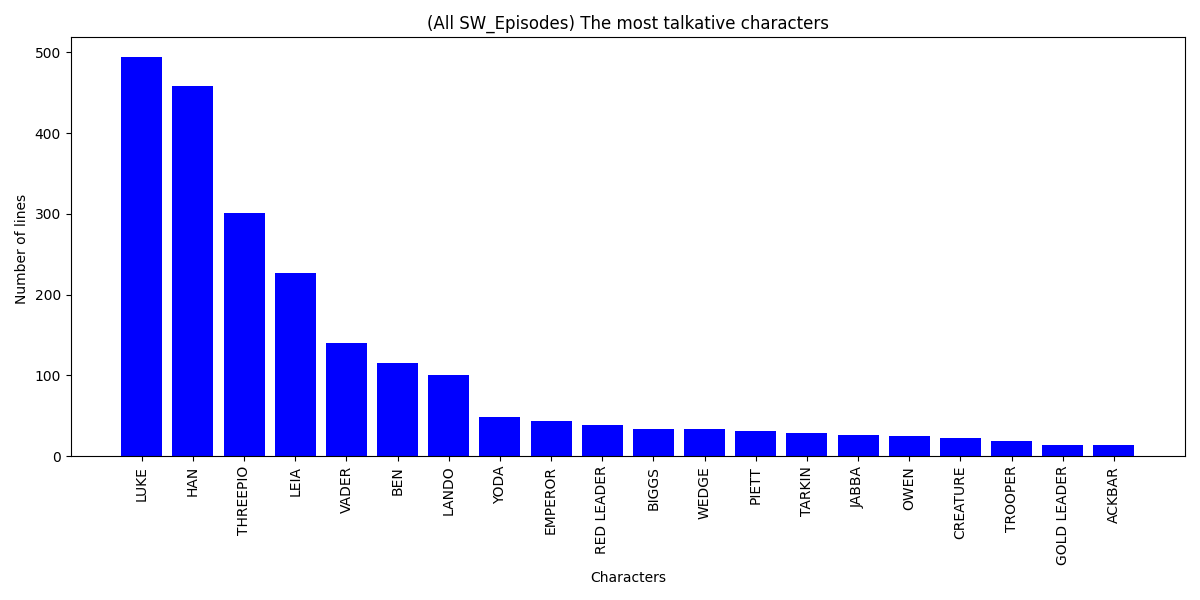

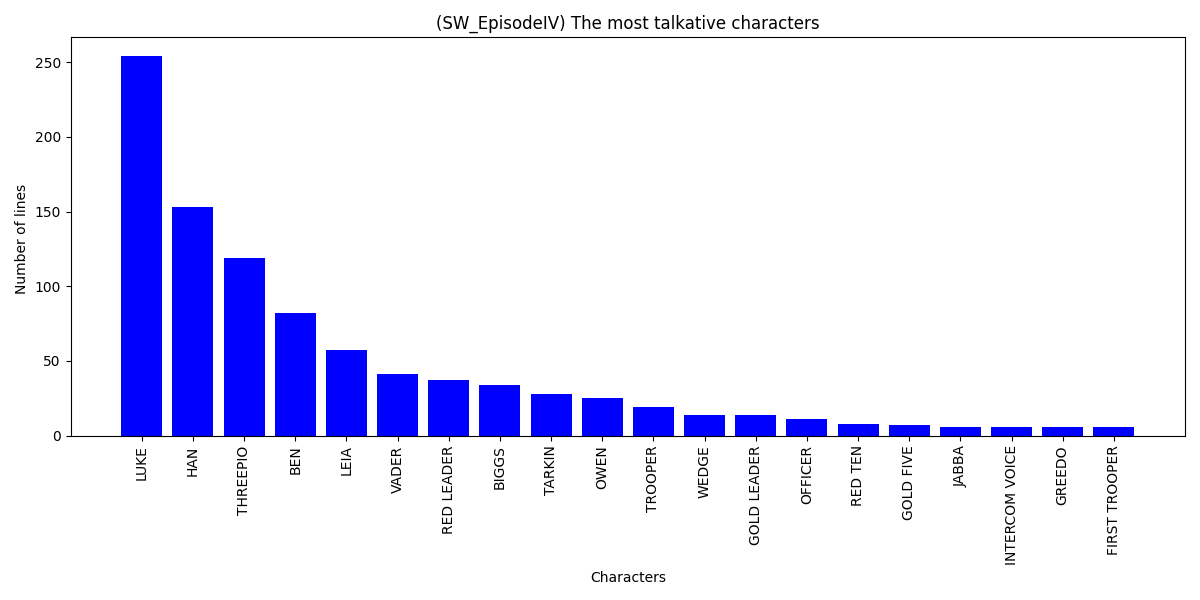

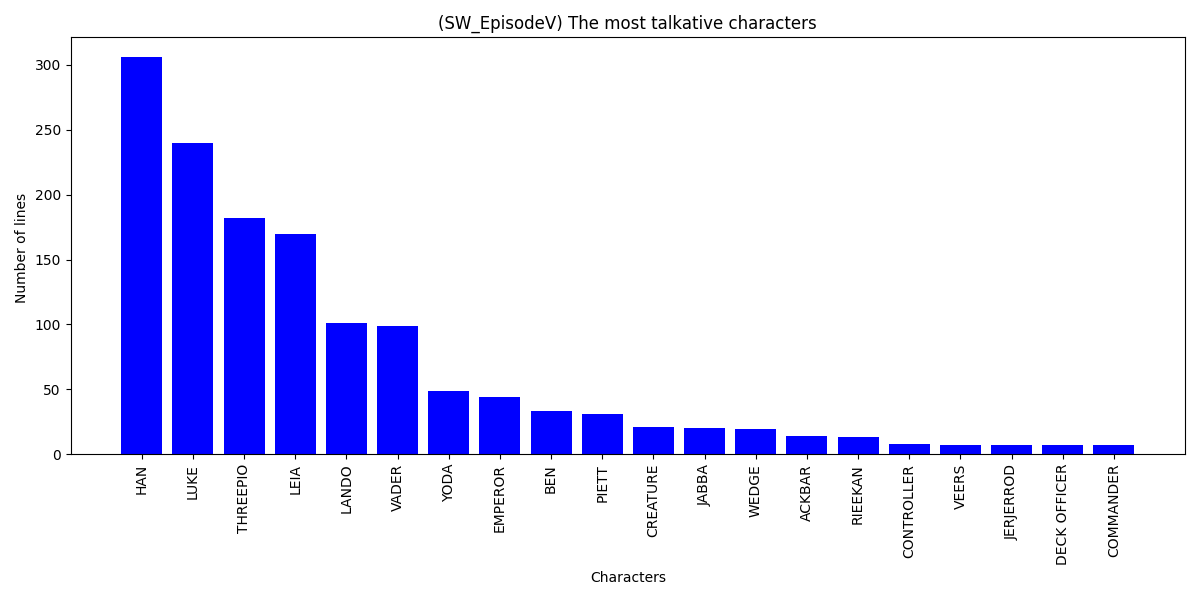

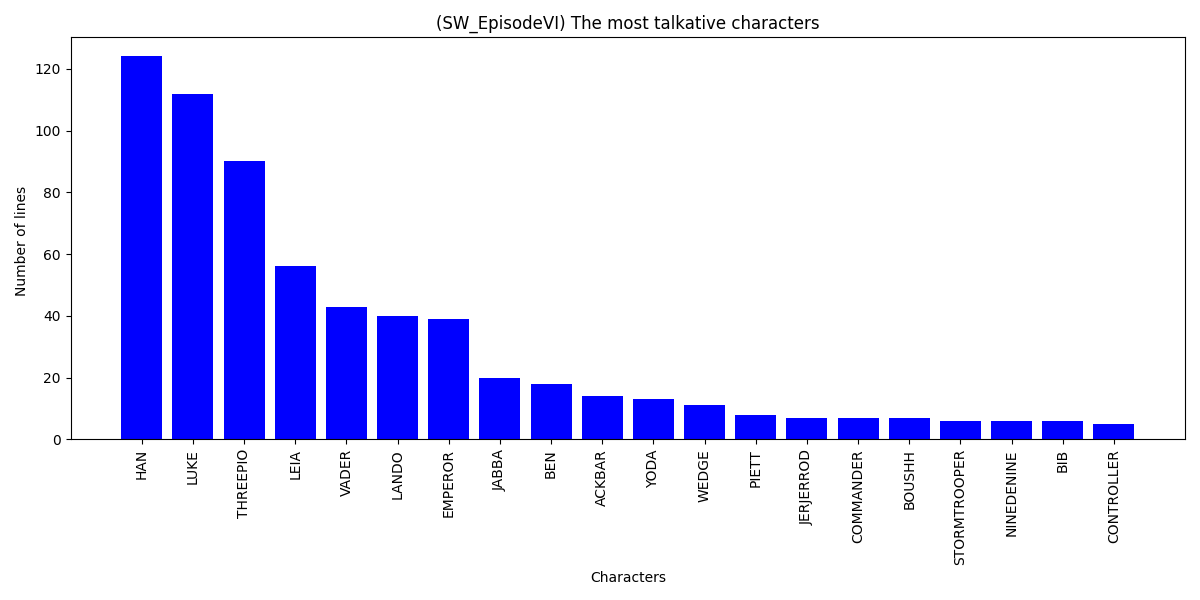

In [35]:
output_graphs('star-wars/task1-images')

## Task #2

In [36]:
%%writefile mrjob_task2.py

from mrjob.job import MRJob, MRStep
import re


def combiner_phrase(character, phrases):
    yield character, max(phrases, key=len)


def reducer_phrase(character, phrases):
    yield None,  (character, max(phrases, key=len))


def reducer_sort_by_phrase_len(_, character_phrases):
    sorted_phrases = sorted(character_phrases, key=lambda x: len(x[1]))
    for character, phrase in sorted_phrases:
        yield character, phrase


class MRCharacterWithTheMostLongPhrase(MRJob):

    def __init__(self, args=None):
        super().__init__(args)
        self.character_regex = None

    def mapper_regex(self):
        self.character_regex = re.compile(r'"\d+"\s+"([\w\s]+?)"\s+"([^"]+)"$')

    def mapper_character_phrase(self, _, line):
        match = self.character_regex.match(line)
        if match:
            character = match.group(1)
            phrase = match.group(2)
            yield character, phrase

    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_regex,
                mapper=self.mapper_character_phrase,
                combiner=combiner_phrase,
                reducer=reducer_phrase
            ),
            MRStep(reducer=reducer_sort_by_phrase_len)
        ]

if __name__ == '__main__':
    MRCharacterWithTheMostLongPhrase.run()


Writing mrjob_task2.py


Local execution example

In [39]:
!python3 mrjob_task2.py star-wars/SW_EpisodeIV.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/mrjob_task2.root.20231129.231423.927337
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/mrjob_task2.root.20231129.231423.927337/output
Streaming final output from /tmp/mrjob_task2.root.20231129.231423.927337/output...
"WINGMAN"	"Yes, sir."
"TROOPER VOICE"	"Open up in there!"
"PORKINS"	"Red Six standing by."
"RED NINE"	"Red Nine standing by."
"RED SEVEN"	"Red Seven standing by."
"DEAK"	"Not again!  Forget it."
"RED ELEVEN"	"Red Eleven standing by."
"CHIEF PILOT"	"There goes another one."
"SECOND TROOPER"	"Maybe it's another drill."
"CREATURE"	"Negola dewaghi wooldugger?!?"
"FIRST OFFICER"	"Follow me!  You stand guard."
"WOMAN"	"I've told you kids to slow down!"
"TECHNICIAN"	"We'll get to work on him right away."
"GOLD TWO"	"Computer's locked.  Getting a signal."
"CAMIE"	"It was just Wormie on another rampage."
"FIRST TROOPER"	"Someone was in the po

Run to sort characters by their longest line

In [42]:
%%bash
#Run mapreduce job to determine most talkative character
scripts=('SW_EpisodeIV' 'SW_EpisodeV' 'SW_EpisodeVI' 'SW_Episode')
for script in "${scripts[@]}"; do
    result=${script}
    [ "${script}" == "SW_Episode" ] && result="All ${script}s"
    python3 mrjob_task2.py -r hadoop "hdfs://namenode:8020/star-wars/${script}*.txt" --conf-path mrjob.conf --output "/star-wars/${result}-task2.results"
done

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/mrjob_task2.root.20231129.233730.523274
uploading working dir files to hdfs:///user/root/tmp/mrjob/mrjob_task2.root.20231129.233730.523274/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/mrjob_task2.root.20231129.233730.523274/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar4017983006192297601/] [] /tmp/streamjob976359745872304165.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701300973946_0001
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_17

In [44]:
%%bash
results=('SW_EpisodeIV' 'SW_EpisodeV' 'SW_EpisodeVI' 'All SW_Episodes')
mkdir -p 'hadoop-notebook/star-wars/task1-images'
cd 'star-wars/task1-images'
for result in "${results[@]}"; do
    echo "---${result}---"
    hadoop fs -cat "/star-wars/${result}-task2.results/part*"
done

---SW_EpisodeIV---
"WINGMAN"	"Yes, sir."
"TROOPER VOICE"	"Open up in there!"
"PORKINS"	"Red Six standing by."
"RED NINE"	"Red Nine standing by."
"RED SEVEN"	"Red Seven standing by."
"DEAK"	"Not again!  Forget it."
"RED ELEVEN"	"Red Eleven standing by."
"CHIEF PILOT"	"There goes another one."
"SECOND TROOPER"	"Maybe it's another drill."
"FIRST OFFICER"	"Follow me!  You stand guard."
"CREATURE"	"Negola dewaghi wooldugger?!?"
"WOMAN"	"I've told you kids to slow down!"
"TECHNICIAN"	"We'll get to work on him right away."
"GOLD TWO"	"Computer's locked.  Getting a signal."
"CAMIE"	"It was just Wormie on another rampage."
"FIRST TROOPER"	"Someone was in the pod.  The tracks go off in this direction. "
"RED TEN"	"There's a heavy fire zone on this side. Red Five, where are you?"
"VOICE OVER DEATH STAR INTERCOM"	"Clear Bay twenty-three-seven.  We are opening the magnetic field."
"CHIEF"	"This R2 unit of your seems a bit beat up.  Do you want a new one?"
"GOLD FIVE"	"I'd say about twenty guns.  So

## Task #3

In [8]:
%%writefile mrjob_task3.py

from mrjob.job import MRJob, MRStep
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

class MRMostCommonBigrams(MRJob):

    def __init__(self, args=None):
        super().__init__(args)
        self.character_regex = None
        if self.options.top_n <= 0:
            self.stderr.write("Error: -n/--top-n must be a positive integer.\n".encode())
            exit(1)

    def configure_args(self):
        super(MRMostCommonBigrams, self).configure_args()
        self.add_passthru_arg('-n', '--top-n', type=int, default=20, help='Number of top bigrams to return (must be positive)')

    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                combiner=self.combiner,
                reducer=self.reducer
            ),
            MRStep(
                reducer=self.reducer_sort_top
            )
        ]

    def mapper_init(self):
        self.character_regex = re.compile(r'"\d+"\s+"[\w\s]+?"\s+"([^"]+)"$')
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('wordnet')
        
    def mapper(self, _, line):
        match = self.character_regex.match(line)
        if match:
            phrase = match.group(1)
            
            stop_words = stopwords.words('english')
            lemmatizer = WordNetLemmatizer()
    
            words = word_tokenize(phrase.lower())
            words = [word for word in words if word.isalnum() and word not in stop_words]
            lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
            for bigram in bigrams(lemmatized_words):
                yield bigram, 1

    def combiner(self, bigram, counts):
        yield bigram, sum(counts)

    def reducer(self, bigram, counts):
        yield None, (sum(counts), bigram)

    def reducer_sort_top(self, _, counts_bigrams):
        top_n = self.options.top_n
        sort_bigrams = sorted(counts_bigrams, key=lambda x: x[0], reverse=True)
        for count, bigram in sort_bigrams[:top_n]:
            yield ' '.join(bigram), count

if __name__ == '__main__':
    MRMostCommonBigrams.run()

Overwriting mrjob_task3.py


Local execution example

In [9]:
!python3 mrjob_task3.py star-wars/SW_EpisodeVI.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/mrjob_task3.root.20231130.021145.439249
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Pac

Run to identify the most frequent bigrams

In [16]:
%%bash
#Run mapreduce job to determine most talkative character
scripts=('SW_EpisodeIV' 'SW_EpisodeV' 'SW_EpisodeVI' 'SW_Episode')
for script in "${scripts[@]}"; do
    result=${script}
    [ "${script}" == "SW_Episode" ] && result="All ${script}s"
    python3 mrjob_task3.py -r hadoop "hdfs://namenode:8020/star-wars/${script}*.txt" --conf-path mrjob.conf --output "/star-wars/${result}-task3.results"
done

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/mrjob_task3.root.20231130.023732.822622
uploading working dir files to hdfs:///user/root/tmp/mrjob/mrjob_task3.root.20231130.023732.822622/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/mrjob_task3.root.20231130.023732.822622/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar6315536403753347357/] [] /tmp/streamjob888125638746011787.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701311840291_0001
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_17

In [21]:
%%bash
results=('SW_EpisodeIV' 'SW_EpisodeV' 'SW_EpisodeVI' 'All SW_Episodes')
mkdir -p 'star-wars/task3-images'
cd 'star-wars/task3-images'
for result in "${results[@]}"; do
    hadoop fs -cat "/star-wars/${result}-task3.results/part*" | plotdata -x 'Bigrams' -y 'Quantities in the text' -e "${result}" -t 'Top most frequent bigrams'
done

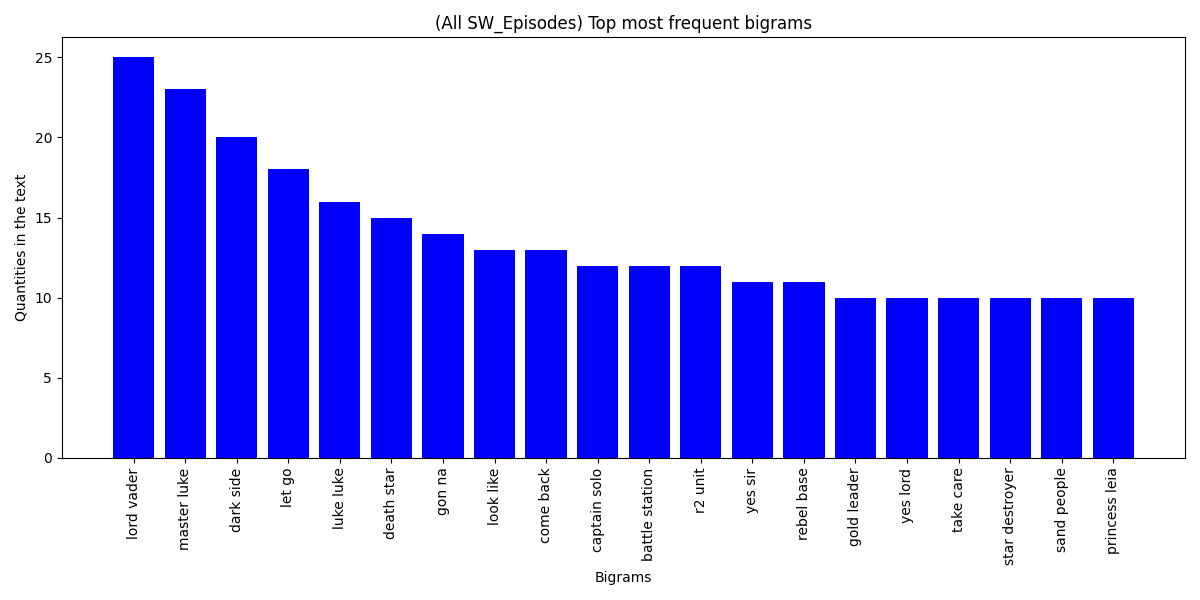

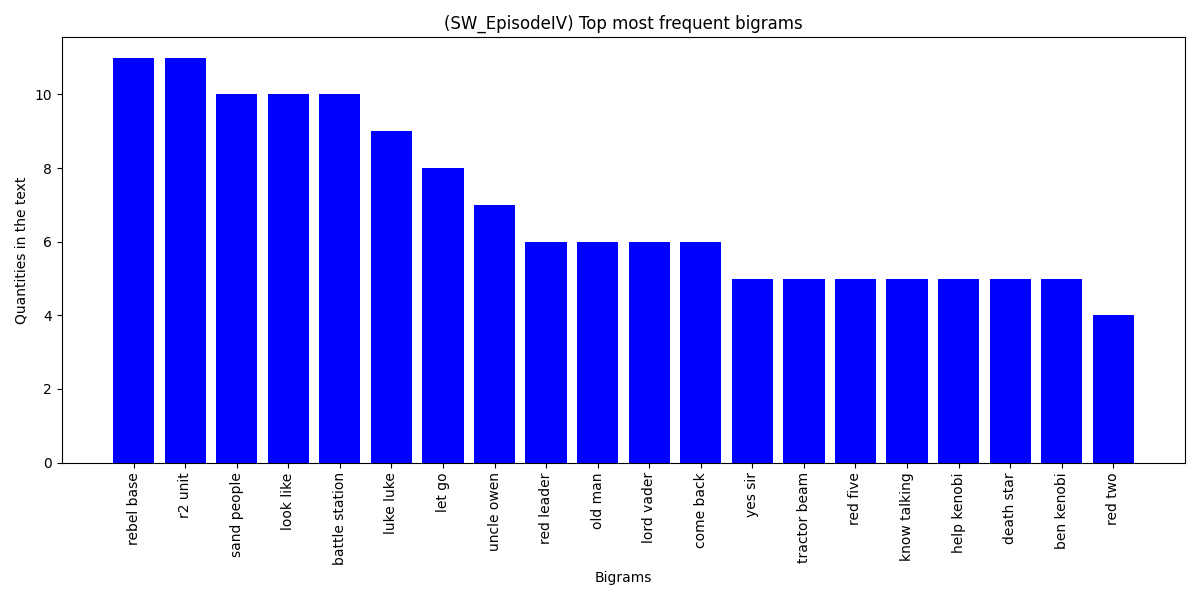

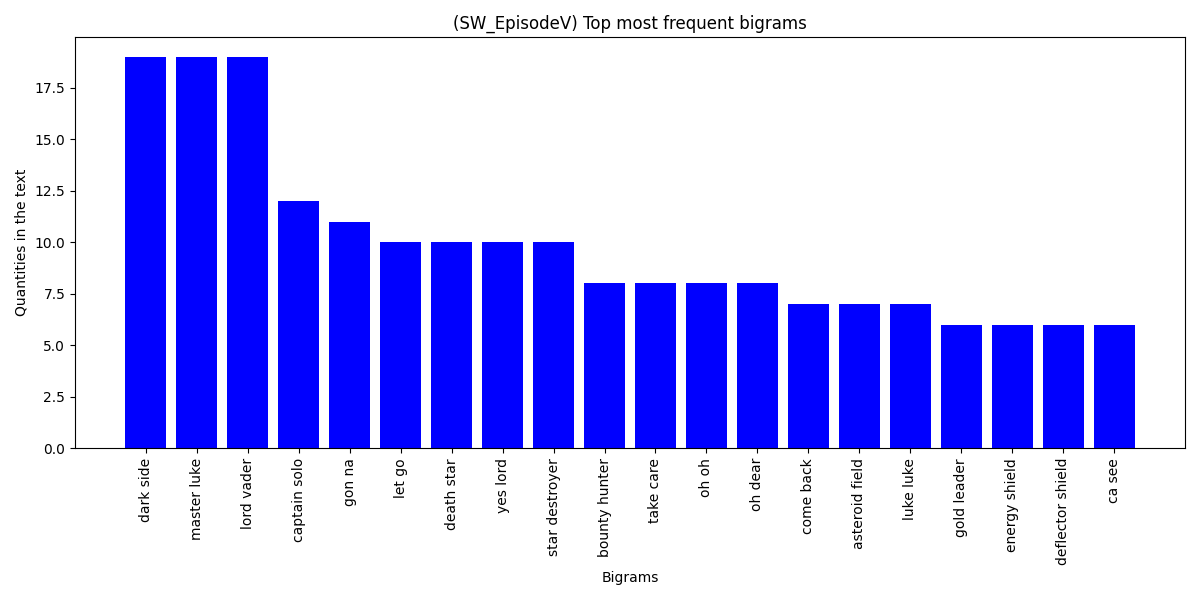

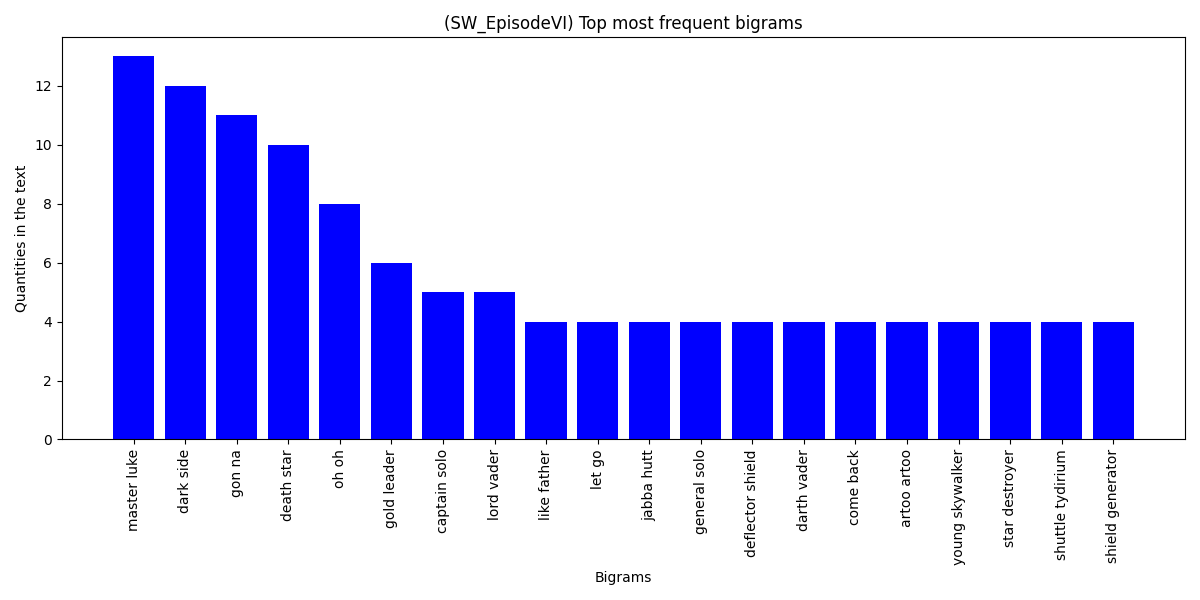

In [22]:
output_graphs('star-wars/task3-images')

### Launched mapreduce jobs example

![nm-1](./images/nm-1.png)
![rm-2](./images/rm-2.png)